# Stacking for Classification

In [15]:
import pandas as pd
# import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

With Stacking, base learners are used for initial predictions, which are fed into a final prediction layer. This way an additional layer of abtraction is created for more accurate prediction. 

Using all data for all models is certain to cause overfitting, so ususally k-fold CV is used.

In [2]:
## HELPER FUNCTION

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        "test Accuracy": 
            metrics.accuracy_score(y_test, model.predict(X_test)),
        "train Accuracy": 
            metrics.accuracy_score(y_train, model.predict(X_train))
        }

## Stacking with Wine Data

We'll use a new dataset consisting of wine data. The following features are included:

1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10) Color intensity
11) Hue
12) OD280/OD315 of diluted wines
13) Proline

With the 'Class' feature being the target column.

There are:

- 178 entries
- 13 feature columns (11 float, 2 int)
- 1 target column (int := [1, 2, 3])

Below, as EDA, correlations are shown both as correlation matrix and as pairplots.

In [3]:
columns = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash' ,'Magnesium', 'Total phenols', 'Flavanoids', 
    'Nonflavanoid phenols', 'Proanthocyanins',     'Color intensity', 'Hue', 'OD280/OD315 of diluted wines','Proline'
    ]

df = pd.read_csv("./data/wine.data", names = columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

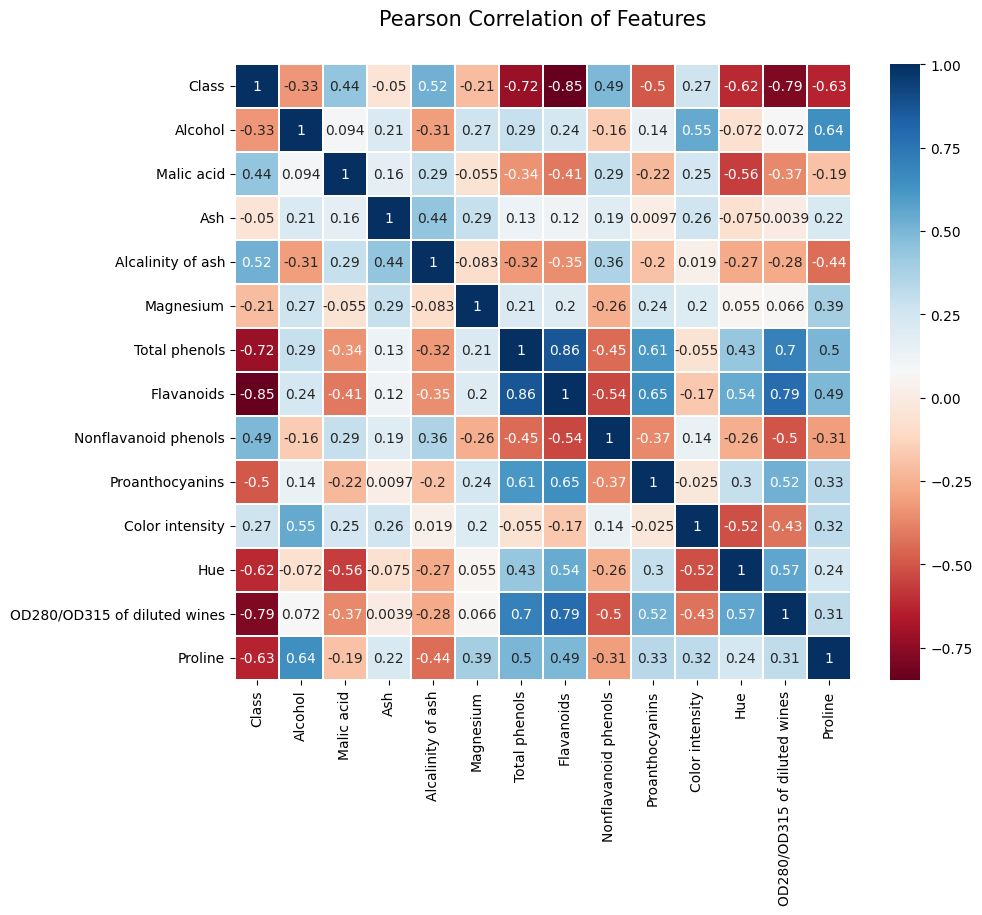

In [4]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Class is correlated (>0.5) with:
- Proline (-)
- OD280/OD315 (-)
- Hue (-)
- Proanthocyanianins (-)
- Nonflavanoid phenols (+)
- Flavanoids (-)
- Total phenols (-)
- Alcalinity of Ash (+)

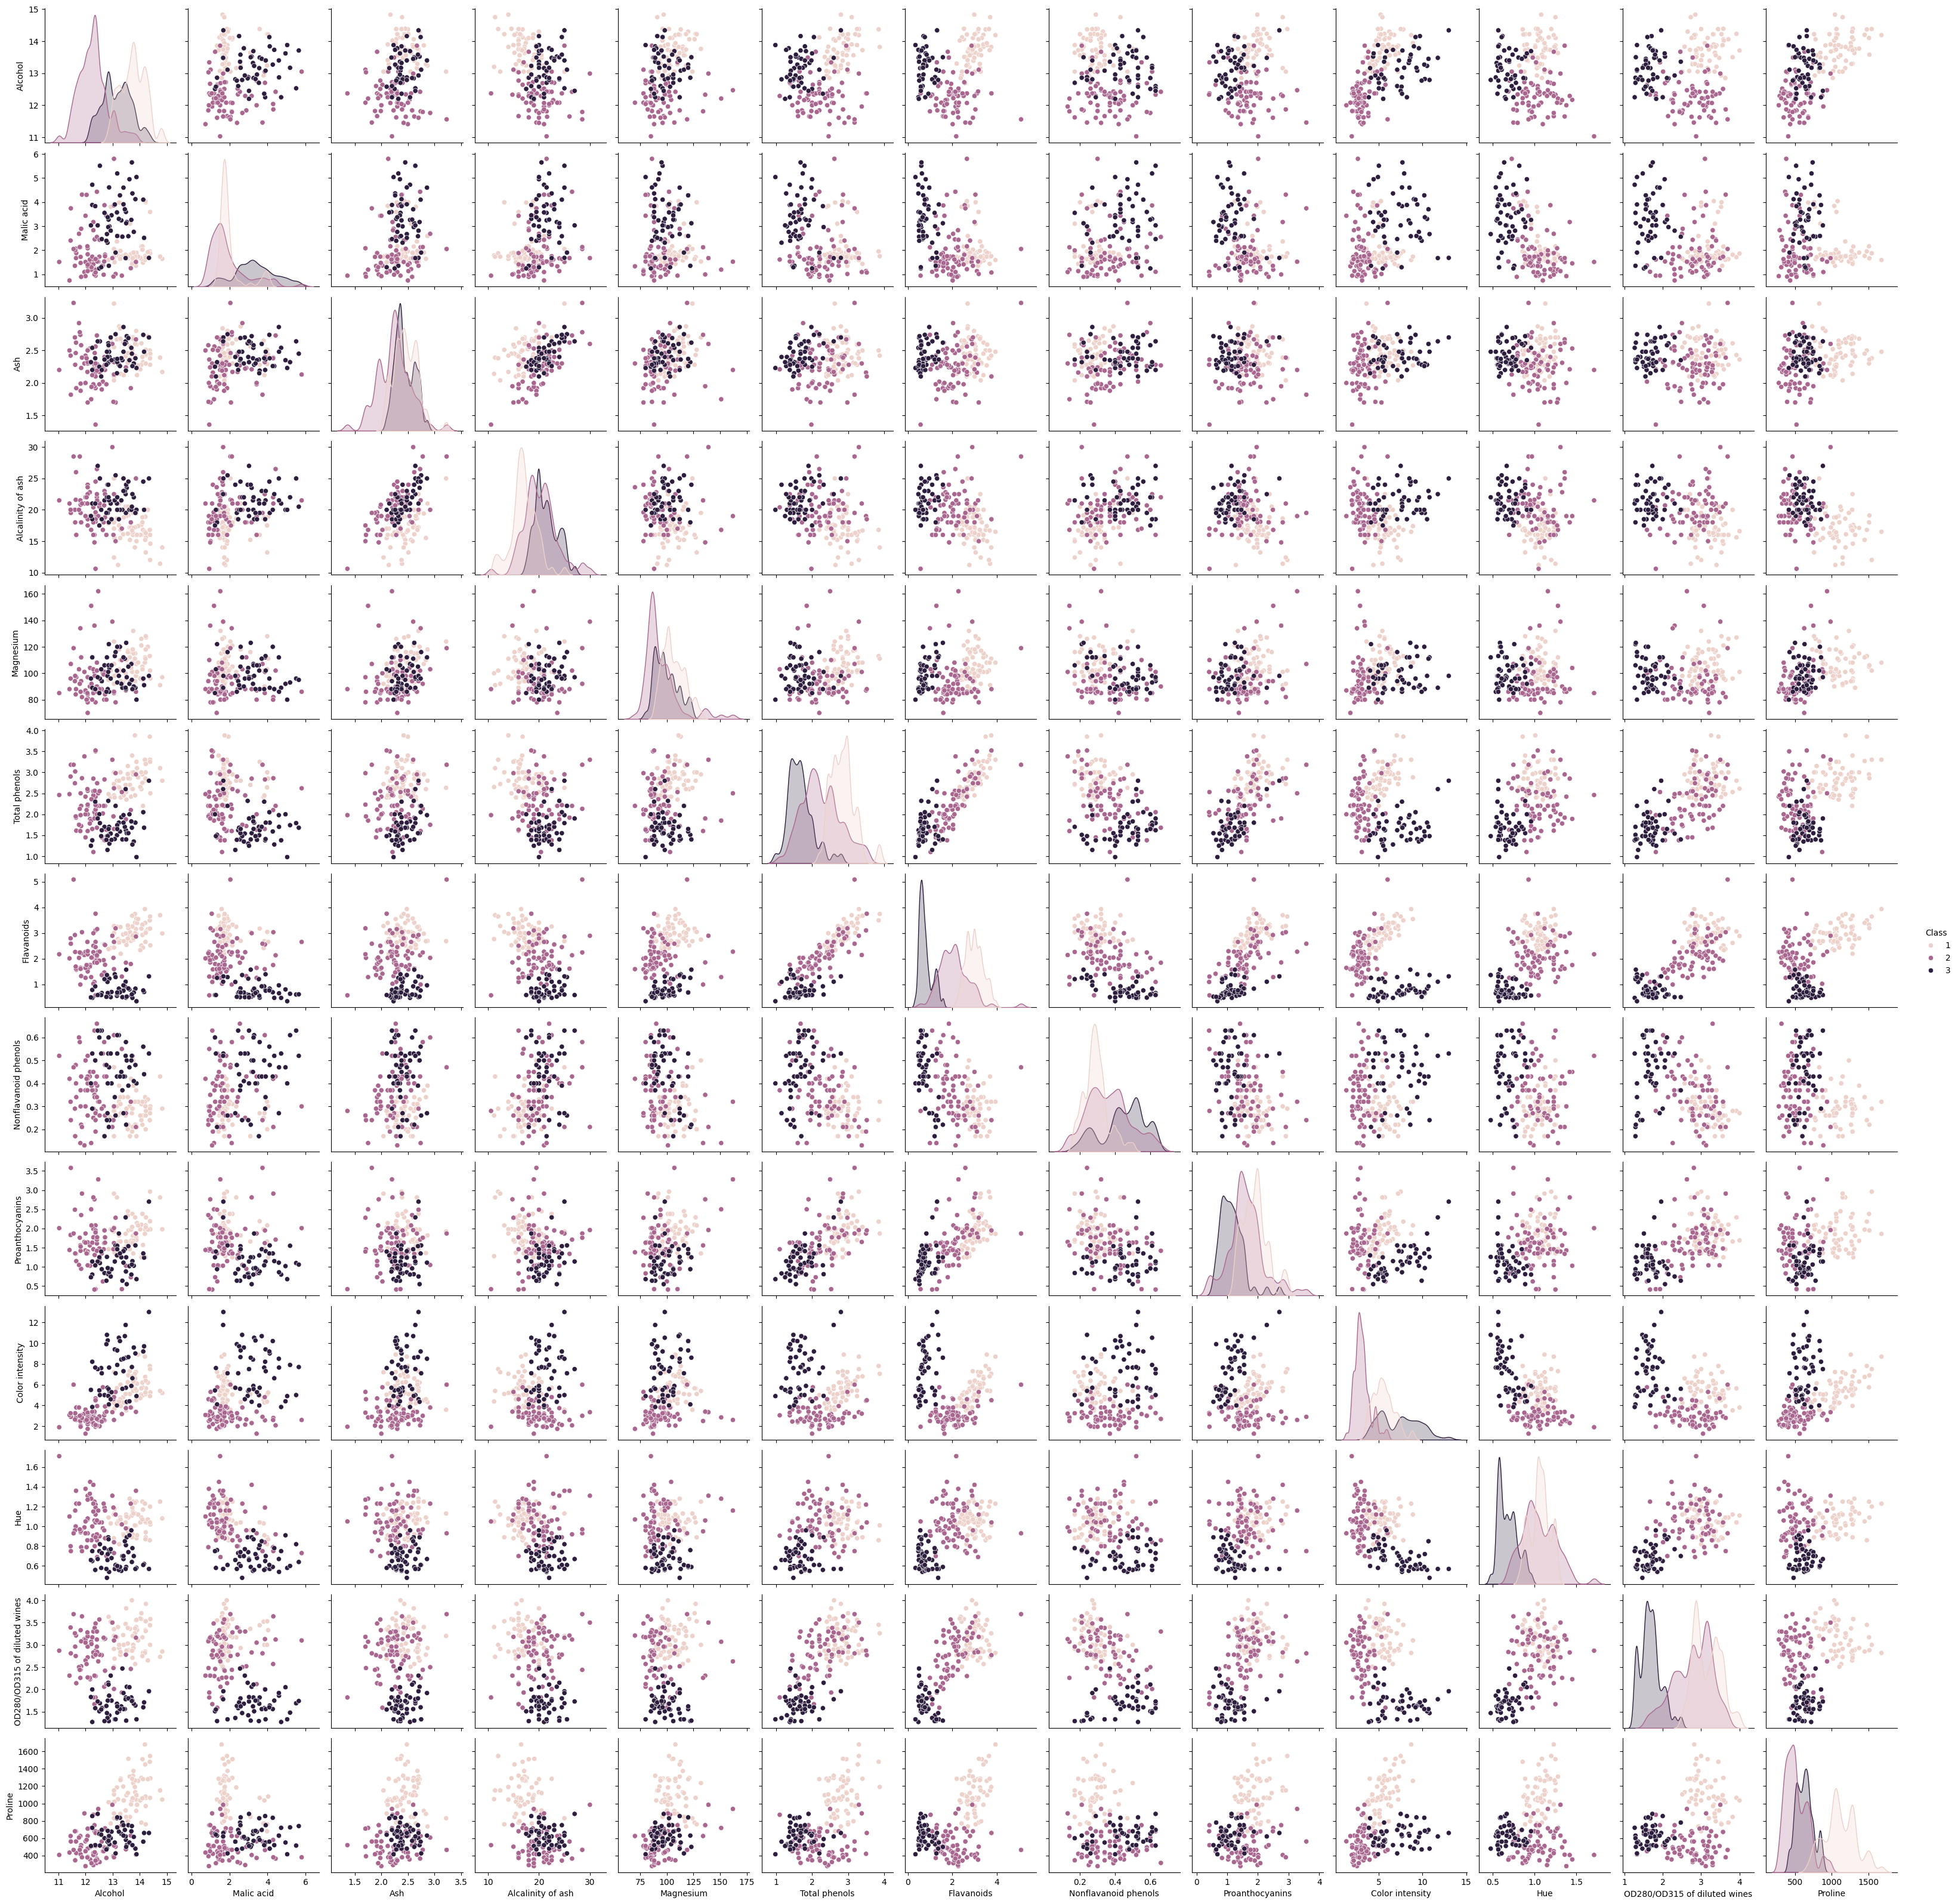

In [6]:
sns.pairplot(df, hue="Class", diag_kws={'bw_method': 0.2})

## Preprocessing

Since we will be using KNN, the data needs to be scaled (otherwise the distance calculation might be skewed towards larger values). Also, we split the data as usual in test/train splits.

In [ ]:
target = "Class"
features = df.drop(columns=[target]).columns.to_list()

X = df[features]
y = df[target]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Model building

We'll use a combination of SVM, KNN and DecisionTrees as our classifiers. A final layer of a simple logistic regression model is used as the output layer.

In [13]:
estimators = [
    ('SVM',SVC(random_state=42)),
    ('KNN',KNeighborsClassifier()),
    ('dt',DecisionTreeClassifier())
    ]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression()
    )

clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

get_accuracy(X_train, X_test, y_train, y_test, clf)

{'test Accuracy': 0.9814814814814815, 'train Accuracy': 1.0}

In [14]:
estimators = [
    ('SVM',SVC(random_state=42)),
    ('KNN',KNeighborsClassifier()),
    ('LR',LogisticRegression())
    ]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=DecisionTreeClassifier()
    )

clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

get_accuracy(X_train, X_test, y_train, y_test, clf)

{'test Accuracy': 0.9814814814814815, 'train Accuracy': 1.0}

As we can see, the train accuracy is perfect, usually an indication that there might be some overfitting. Though performance on the test data is also quite good. More complex models tend to overfit.

## Gridsearching the stack

As usual, we can now build a gridsearch setup to find the optimal parameters for the model. For this we will once again use the drug data from earlier.

In [ ]:
df = pd.read_csv("./data/drug200.csv")

features = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
target = 'Drug'

X = df[features]
y = df[target]

le_sex = LabelEncoder()
X.loc[:, 'Sex'] = le_sex.fit_transform(X['Sex'])

le_BP = LabelEncoder()
X.loc[:, 'BP'] = le_BP.fit_transform(X['BP'])

le_Chol = LabelEncoder()
X.loc[:, 'Cholesterol'] = le_Chol.fit_transform(X['Cholesterol'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

estimators = [
    ('SVC', SVC(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier())
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

param_grid = {
    "DT__max_depth": [n for n in range(10)],
    "SVC__kernel": ['linear', 'poly', 'rbf'],
    "KNN__n_neighbors": [1,4,8,9]
}

search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="accuracy"
)

search.fit(X_train, y_train)

search.best_score_, search.best_params_

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\ensemble\_stacking.py", line 706, in fit
    return super().fit(X, y_encoded, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "p:\02_Poetry

(np.float64(1.0),
 {'DT__max_depth': 4, 'KNN__n_neighbors': 4, 'SVC__kernel': 'poly'})

In [19]:
get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_)

{'test Accuracy': 0.95, 'train Accuracy': 1.0}

From this we can see that, even though some of the fits fail, gridsearch optimizes the chosen parameters for each of the classifiers in the stacking model.